In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
print(os.listdir("data"))

['2015-building-energy-benchmarking.csv', '2016-building-energy-benchmarking.csv', 'clean-building-energy-benchmarking.csv', 'socrata_metadata_2015-building-energy-benchmarking.json', 'socrata_metadata_2016-building-energy-benchmarking.json']


In [2]:
raw = pd.read_csv("data/clean-building-energy-benchmarking.csv")
data = raw.copy()

In [3]:
data.head()

,DataYear,ENERGYSTARScore,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,SiteEnergyUseWN(kBtu),TotalGHGEmissions,YearBuilt,...,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,ENERGYSTARCertified
0,2015,65.0,1.0,12.0,88434,0,88434,7097539.0,249.43,1927,...,0,0,0,0,0,0,0,0,0,0
1,2015,51.0,1.0,11.0,88502,15064,103566,8765788.0,263.51,1996,...,0,0,0,0,0,0,0,0,0,0
2,2015,18.0,1.0,41.0,961990,0,961990,NaN,NaN,1969,...,0,0,0,0,0,0,0,0,0,0
3,2015,NaN,1.0,10.0,61320,0,61320,28363444.0,NaN,1926,...,0,0,0,0,0,0,0,0,0,0
4,2015,67.0,1.0,18.0,107430,12460,119890,15078243.0,507.70,1980,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
def test(models, X_train, X_test, y_train, y_test):
    results = []
    for i, model in enumerate(models):
        start_time = time.time()
        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_test)
        r2_predict = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        end_time = time.time() - start_time
        results.append([r2_predict, rmse, end_time])
    return pd.DataFrame(results, columns=["R2 Score", "RMSE", "Time"], index=models.keys())

# TotalGHGEmissions

In [6]:
df = data.copy()
df.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [7]:
X = df.drop(["TotalGHGEmissions", "SiteEnergyUseWN(kBtu)", "ENERGYSTARScore"], axis=1)
y = df[["TotalGHGEmissions"]]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
models = {'OLS': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge(),
          'SVM': SVR(kernel="linear"),
          'Random Forest': RandomForestRegressor(),
         }

In [12]:
baseline_ghg = test(models, X_train, X_test, y_train, y_test)

In [13]:
baseline_ghg

,R2 Score,RMSE,Time
OLS,0.494262,73.596899,10.106966
Lasso,0.503838,72.896814,0.269280
Ridge,0.494284,73.595319,0.122672
SVM,0.468797,75.426979,4.713901
Random Forest,0.574714,67.489683,0.698133


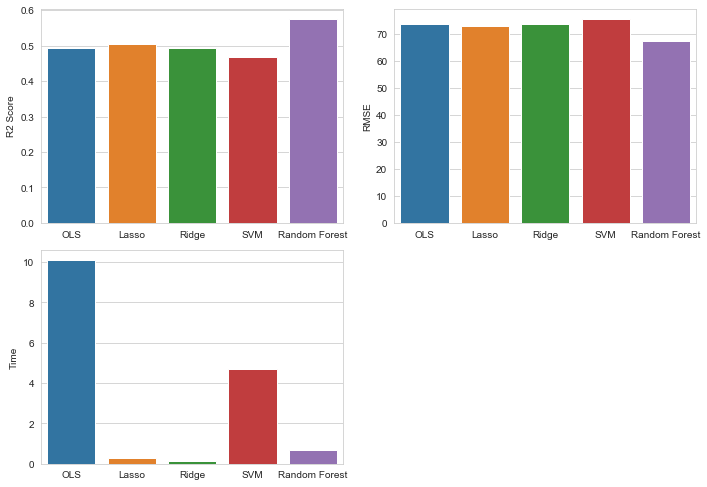

In [14]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(baseline_ghg.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=baseline_ghg.index, y=column, data=baseline_ghg)
plt.tight_layout()
plt.show()

### Optimisation des models

In [15]:
lasso_params = {'alpha': np.logspace(-2, -1, 20)}

grid_lasso = GridSearchCV(Lasso(), param_grid=lasso_params, n_jobs=-1, verbose = 5)
grid_lasso.fit(X_train, y_train)
grid_lasso.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:    9.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed:    9.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.9s finished


Lasso(alpha=0.0379269019073225, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
ridge_params = {'alpha': np.logspace(-5, 5, 20)}

grid_ridge = GridSearchCV(Ridge(), param_grid=ridge_params, n_jobs=-1, verbose = 5)
grid_ridge.fit(X_train, y_train)
grid_ridge.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  60 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  29 out of  60 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished


Ridge(alpha=69.51927961775606, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [17]:
svm_params = {'kernel': ['linear'], 'C': np.logspace(0, 2, 3)}
grid_svm = GridSearchCV(SVR(), param_grid=svm_params, n_jobs=-1, verbose = 5)
grid_svm.fit(X_train, y_train)
grid_svm.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    3.5s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    5.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    6.2s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   26.0s finished


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [18]:
rfr_params = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000]}

random_rfr = RandomizedSearchCV(RandomForestRegressor(), param_distributions=rfr_params, n_iter=100, cv=3, verbose=5, n_jobs=-1)
random_rfr.fit(X_train, y_train)
random_rfr.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.0min finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=40,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [19]:
models2 = {'OLS': LinearRegression(),
           'Lasso': grid_lasso.best_estimator_,
           'Ridge': grid_ridge.best_estimator_,
           'SVM': grid_svm.best_estimator_,
           'Random Forest': random_rfr.best_estimator_}

In [20]:
optimize_ghg = test(models2, X_train, X_test, y_train, y_test)
optimize_ghg

,R2 Score,RMSE,Time
OLS,0.494262,73.596899,0.011966
Lasso,0.494907,73.549929,0.363029
Ridge,0.496479,73.435376,0.005984
SVM,0.468797,75.426979,3.561712
Random Forest,0.789335,47.499885,22.588645


In [21]:
scores_ghg = pd.concat([baseline_ghg, optimize_ghg], keys=['Baseline', 'Optimize'])
scores_ghg.round(3)

R2 Score    RMSE    Time
Baseline OLS               0.494  73.597  10.107
         Lasso             0.504  72.897   0.269
         Ridge             0.494  73.595   0.123
         SVM               0.469  75.427   4.714
         Random Forest     0.575  67.490   0.698
Optimize OLS               0.494  73.597   0.012
         Lasso             0.495  73.550   0.363
         Ridge             0.496  73.435   0.006
         SVM               0.469  75.427   3.562
         Random Forest     0.789  47.500  22.589

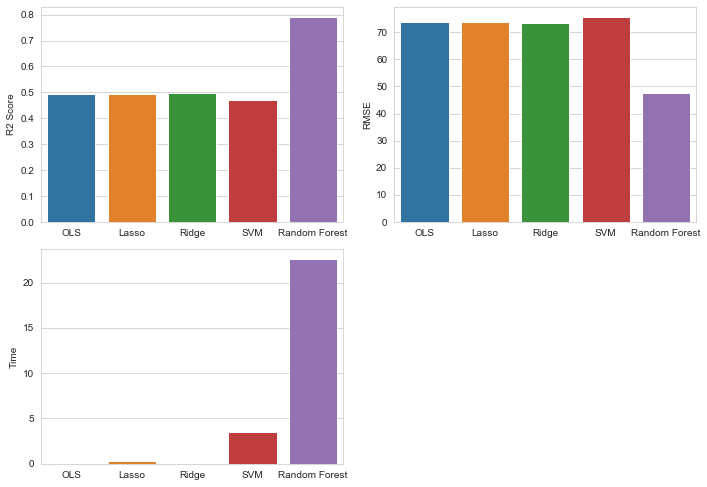

In [22]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(optimize_ghg.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=optimize_ghg.index, y=column, data=optimize_ghg)
plt.tight_layout()
plt.show()

## SiteEnergyUseWN(kBtu)

In [23]:
df = data.copy()
df.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [24]:
X = df.drop(["TotalGHGEmissions", "SiteEnergyUseWN(kBtu)", "ENERGYSTARScore"], axis=1)
y = df[["SiteEnergyUseWN(kBtu)"]]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [26]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [27]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [28]:
baseline_energy = test(models, X_train, X_test, y_train, y_test)

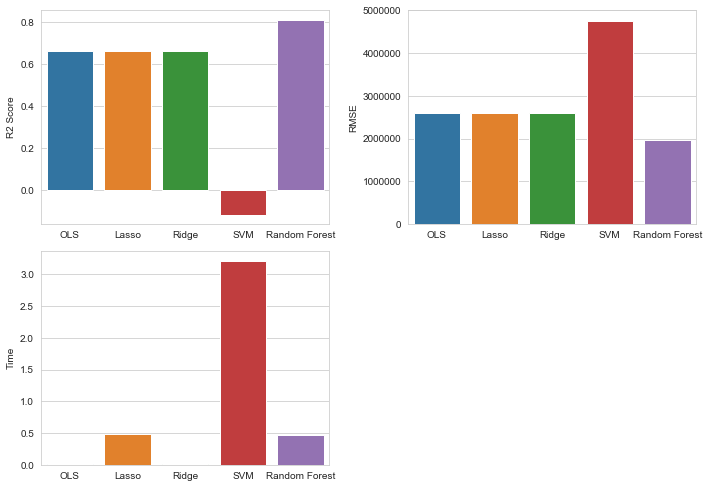

In [29]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(baseline_energy.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=baseline_energy.index, y=column, data=baseline_energy)
plt.tight_layout()
plt.show()

In [30]:
optimize_energy = test(models2, X_train, X_test, y_train, y_test)

In [31]:
scores_energy = pd.concat([baseline_energy, optimize_energy], keys=['Baseline', 'Optimize'])
scores_energy.round(3)

R2 Score         RMSE    Time
Baseline OLS               0.665  2606976.719   0.014
         Lasso             0.665  2606918.810   0.487
         Ridge             0.665  2606822.589   0.007
         SVM              -0.118  4762318.492   3.209
         Random Forest     0.811  1958679.350   0.467
Optimize OLS               0.665  2606976.719   0.012
         Lasso             0.665  2606921.476   0.473
         Ridge             0.667  2601154.322   0.008
         SVM              -0.118  4762318.492   3.193
         Random Forest     0.857  1706037.006  22.421

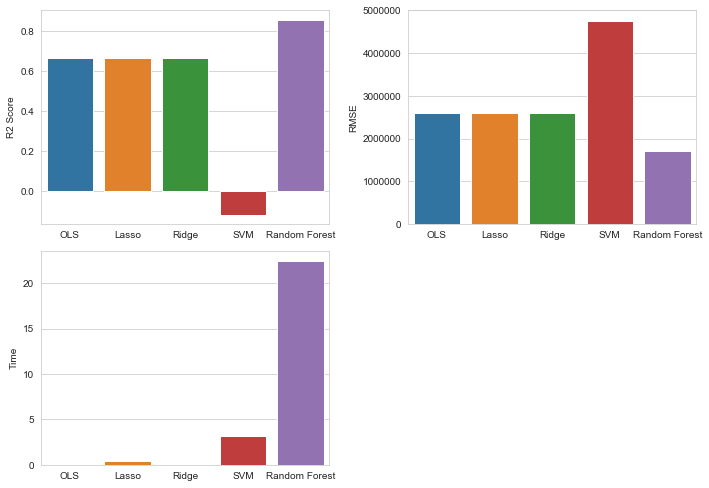

In [32]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(optimize_energy.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=optimize_ghg.index, y=column, data=optimize_energy)
plt.tight_layout()
plt.show()

## EnergyStarScore

Nous allons mesurer l'intérêt de l'EnergyStarScore pour la prédiction de TotalGHGEmissions

In [33]:
df = data.copy()
df.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [34]:
X = df.drop(["TotalGHGEmissions", "SiteEnergyUseWN(kBtu)"], axis=1)
y = df[["TotalGHGEmissions"]]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [36]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [37]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [38]:
baseline_ghg_ess = test(models, X_train, X_test, y_train, y_test)

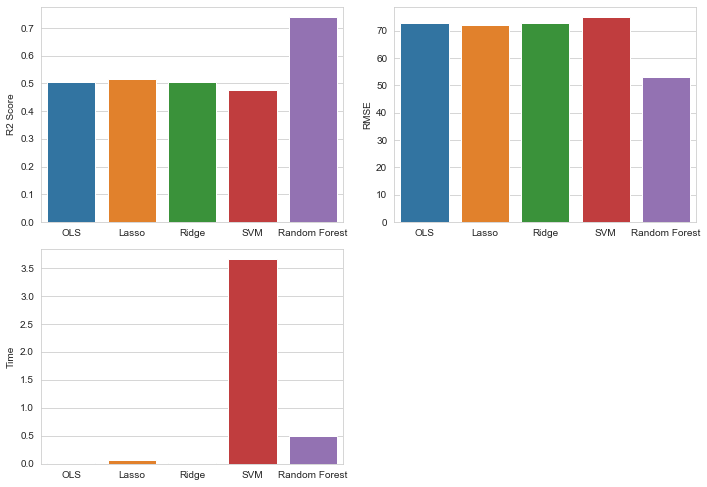

In [39]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(baseline_ghg_ess.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=baseline_ghg_ess.index, y=column, data=baseline_ghg_ess)
plt.tight_layout()
plt.show()

In [40]:
optimize_ghg_ess = test(models2, X_train, X_test, y_train, y_test)

In [41]:
scores_ghg_ess = pd.concat([baseline_ghg_ess, optimize_ghg_ess], keys=['Baseline', 'Optimize'])
scores_ghg_ess.round(3)

R2 Score    RMSE    Time
Baseline OLS               0.506  72.723   0.013
         Lasso             0.515  72.076   0.069
         Ridge             0.506  72.758   0.007
         SVM               0.476  74.879   3.659
         Random Forest     0.738  52.944   0.497
Optimize OLS               0.506  72.723   0.020
         Lasso             0.506  72.712   0.349
         Ridge             0.508  72.599   0.005
         SVM               0.476  74.879   3.580
         Random Forest     0.809  45.248  22.550

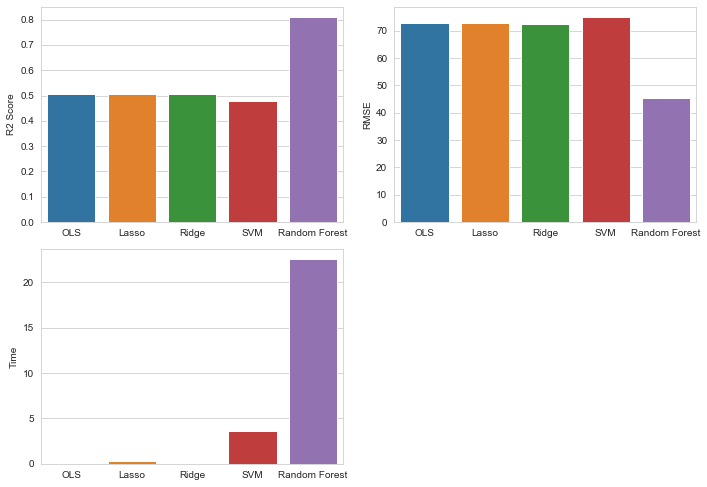

In [42]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(optimize_ghg_ess.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=optimize_ghg_ess.index, y=column, data=optimize_ghg_ess)
plt.tight_layout()
plt.show()

In [43]:
final_ghg = pd.concat([scores_ghg, scores_ghg_ess], keys=["Sans EnergyStarScore", "Avec EnergyStarScore"])
final_ghg.round(2)

R2 Score   RMSE   Time
Sans EnergyStarScore Baseline OLS                0.49  73.60  10.11
                              Lasso              0.50  72.90   0.27
                              Ridge              0.49  73.60   0.12
                              SVM                0.47  75.43   4.71
                              Random Forest      0.57  67.49   0.70
                     Optimize OLS                0.49  73.60   0.01
                              Lasso              0.49  73.55   0.36
                              Ridge              0.50  73.44   0.01
                              SVM                0.47  75.43   3.56
                              Random Forest      0.79  47.50  22.59
Avec EnergyStarScore Baseline OLS                0.51  72.72   0.01
                              Lasso              0.51  72.08   0.07
                              Ridge              0.51  72.76   0.01
                              SVM                0.48  74.88   3.66
                              Random Forest      0.74  52.94   0.50
                     Optimize OLS                0.51  72.72   0.02
                              Lasso              0.51  72.71   0.35
                              Ridge              0.51  72.60   0.00
                              SVM                0.48  74.88   3.58
                              Random Forest      0.81  45.25  22.55

On peut noter que EnergyStarScore a un intérêt ici, on ce retrouve avec des models plus performant en prenant en compte EnergyStarScore.

On peut également noté que le model RandomForestRegressor est bien plus performant que les autres models, notre choix s'arrêtera donc dessus.